In [1]:
import geopandas as gpd
from osgeo import gdal,gdalnumeric
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [3]:
def saveim(filename,im,srs,geo):
    nb,nrow,ncol = im.shape
    driver = gdal.GetDriverByName('GTiff')    
    outDs = driver.Create(filename,ncol,nrow,nb,gdal.GDT_Float32)
    if None is not geo:
        outDs.SetGeoTransform(geo)
    if None is not srs:
        outDs.SetProjection(srs)
    for i in range(nb):
        outBand = outDs.GetRasterBand(i+1)
        outBand.WriteArray(im[i,:,:])
    
    outBand = None
    outDs = None


In [4]:
#定义读取矢量函数
def read_shp(shp_path):    
    vector = gpd.read_file(shp_path)
    return vector
#定义读取栅格函数
def read_raster(raster_path):
    
    data = gdal.Open(raster_path)
    im_width = data.RasterXSize    #栅格矩阵的列数
    im_height = data.RasterYSize   #栅格矩阵的行数        
    gt = data.GetGeoTransform()#仿射矩阵
    crs = data.GetProjection()#地图投影信息
    data_array = data.ReadAsArray(0,0,im_width,im_height)#转化为矩阵
    return data,data_array,gt,crs

In [5]:
def geoToPixel(record,GeoTransform):
    """
    http://www.gdal.org/gdal_tutorial.html

    GeoTransform[0] /* top left x */
    GeoTransform[1] /* w-e pixel resolution */
    GeoTransform[2] /* 0 */
    GeoTransform[3] /* top left y */
    GeoTransform[4] /* 0 */
    """
    uper_left_x = float(GeoTransform[0])
    uper_left_y = float(GeoTransform[3])
    pixel_width = float(GeoTransform[1])
    pixel_height = float(GeoTransform[5])
    (mx, my) = (record[0], record[1])
    px = int((mx - uper_left_x) / pixel_width)  # x pixel
    py = int((my - uper_left_y) / pixel_height)  # y pixel
    return px,py

In [6]:
vector = read_shp(r'./使用数据/裁剪矢量.shp')
data,data_gray,gt,crs = read_raster(r'./使用数据/裁剪用影像.tif')
poly = vector.iloc[0]['geometry']

minX,maxX = min(poly.envelope.exterior.coords.xy[0]),max(poly.envelope.exterior.coords.xy[0])
minY,maxY = min(poly.envelope.exterior.coords.xy[1]),max(poly.envelope.exterior.coords.xy[1])

uper_left_X, uper_left_Y = geoToPixel((minX,maxY),gt)
lower_right_X, lower_right_Y = geoToPixel((maxX,minY),gt)

In [7]:
uper_left_X, uper_left_Y,lower_right_X, lower_right_Y

(512, 2087, 1155, 2811)

In [8]:
gt2 = list(gt)
gt2[0] = minX
gt2[3] = maxY

pxWidth = int(lower_right_X - uper_left_X)
pxHeight = int(lower_right_Y - uper_left_Y)
clip1 = data.ReadAsArray(int(uper_left_X),int(uper_left_Y),int(pxWidth),int(pxHeight))

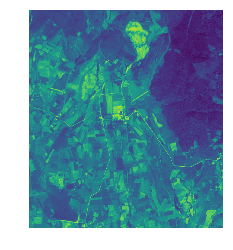

In [9]:
plt.axis('off')
plt.imshow(clip1[1])
plt.savefig(r'F:\python林业资源\出图/裁剪范围.png',dpi=300)

In [10]:
ext_pix = np.array([geoToPixel(points,gt2) for points in poly.exterior.coords])
ext_pix = np.expand_dims(ext_pix,axis=0)
mask = np.ones([pxHeight,pxWidth], np.uint8)

mask = cv2.fillPoly(mask,ext_pix,0)

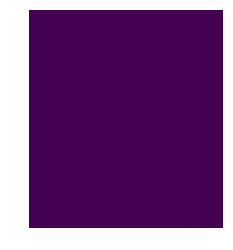

In [11]:
plt.axis('off')
plt.imshow(mask)
plt.savefig(r'F:\python林业资源\出图/裁剪掩膜制作.png',dpi=300)

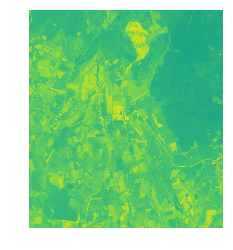

In [12]:
clip = gdalnumeric.choose(mask, (clip1,0))  
plt.axis('off')
plt.imshow(clip[1]) 
plt.savefig(r'F:\python林业资源\出图/裁剪后.png',dpi=300)